# Create your own ims2D map from data extracted from BenzDB

## Quick and not so dirty
If you are not interested in tuning the ims2D map, just modify the following :

In [ ]:
# This cell contains the list of variables and their values that are already defined in the notebook.
# These variables are used throughout the notebook for data processing, visualization, and file handling.

# Directory that contains the data files
dirname="../data"
# Name of the molecule
molecule_name="0-1-3"
# Map type to be generated
map_type="R" # can be "R" or "U"

In [ ]:
# The following variables are used to set the parameters for the visualization
geomfile="{}/{}_reopt.xyz".format(dirname, molecule_name)
csvfile="{}/{}_{}.csv".format(dirname, map_type, molecule_name)

ims3d_color_scale=True #True or False

show_atoms=True #True or False
show_bonds=True #True or False

save_as_image=True # True or False
image_format="png" # "png" by default

## Setup
In a first step, we shall defined functions, which will be used to treat the data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import KDTree

def getBonds(points):
    """
    This function takes a liste of 3D coordiantes as input and returns the three closest atoms of each
    atom at a maximum distance of 1.9 angstrom.
    This allows to draw bonds if required.
    """

# Create a KDTree
    tree = KDTree(points)

# Define max distance
    max_distance = 1.9

# Find the 4 closests neigbourg (including atom itself)
# within maximal distance
    distances, indices = tree.query(points, k=4, distance_upper_bound=max_distance)

# Treat results
    bonds = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        for d, j in zip(dist[1:], idx[1:]):  # Start at 1 to exclude atom itself
            if d <= max_distance:
                bonds.append([i,j])
    return bonds

def getCoords(geomfile):
    """
    Returns labels and coordinates from an xyz file
    """
    thrs=1e-6
    with open(geomfile) as fd:
        coords = []
        labels = []
        for line in fd.readlines()[2:]:
            lbl, x, y, z = line.split()
            labels.append(lbl)
            coords.append([float(x), float(y), float(z)])
        coords=np.array(coords)

    ptp = np.ptp(coords, axis=0)
    if (ptp[0]<thrs):
        # 0, 1, 2
        coords[:, [0,2]] = coords[:, [2,0]]
        # 2, 1, 0
    #    coords[:, [0,1]] = coords[:, [1,0]]
        # 1, 2, 0
    elif (ptp[1]<thrs):
        # 0, 1, 2
        coords[:, [0,1]] = coords[:, [1,0]]
        # 1, 0, 2
        coords[:, [0,2]] = coords[:, [2,0]]
        # 2, 0, 1
    return labels, coords



In [7]:
def getDataFromCSV(filename):
    """
    Returns data extracted from the csv file
    """
    fd = open(filename, "r")
    VectX = [0,0,0]
    VectY = [0,0,0]
    Origin = [0,0,0]
    for line in fd.readlines():
        if "VectX" in line:
            _, x, y, z = line.split(',')
            VectX[0], VectX[1], VectX[2] = float(x), float(y), float(z)
        elif "VectY" in line:
            _, x, y, z = line.split(',')
            VectY[0], VectY[1], VectY[2] = float(x), float(y), float(z)
        elif "nbPtsX" in line:
            _, n = line.split(',')
            nX = int(n)
        elif "nbPtsY" in line:
            _, n = line.split(',')
            nY = int(n)
        elif "origin" in line:
            _, x, y, z = line.split(',')
            Origin[0], Origin[1], Origin[2] = float(x), float(y), float(z)
        elif "points" in line:
            data = [float(line.split(',')[1:][i]) for i in range(nX*nY)]
    return Origin, VectX, VectY, nX, nY, data

## Definition of the plot

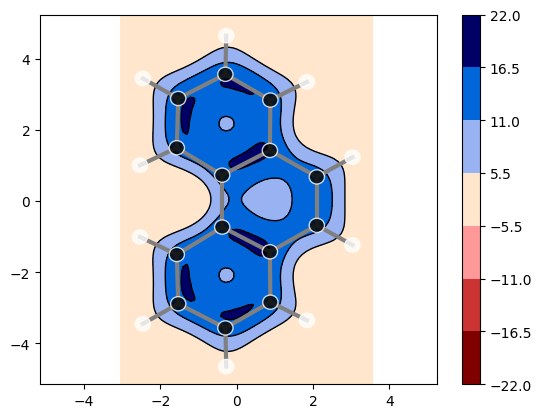

In [8]:
labels, coords = getCoords(geomfile)
bonds=getBonds(coords)
Origin, VectX, VectY, nX, nY, data = getDataFromCSV(csvfile)

X, Y = np.meshgrid(np.linspace(Origin[1], Origin[1]+nY*VectY[1], nY)
                   , np.linspace(Origin[0], Origin[0]+nX*VectX[0], nX))

Z = np.array(data).reshape(nX,nY)

#
# Definition of the color scale
#
if ims3d_color_scale:
    colors = [(0.5, 0.0, 0.0),
              (0.8, 0.2, 0.2),
              (1.0, 0.6, 0.6),
              (1.0, 0.9, 0.8),
              (0.6, 0.7, 0.95),
              (0.0, 0.4, 0.85),
              (0.0, 0.0, 0.4)]

levels = [-22, -16.5, -11, -5.5, 5.5, 11, 16.5, 22]

# plot
fig, ax = plt.subplots()

#
# Adding contours
#
if ims3d_color_scale:
    contours = ax.contourf(X, Y, Z, levels=levels, colors=colors)
else:
    contours = ax.contourf(X, Y, Z)
    
isocontours = ax.contour(X, Y, Z, levels=levels, colors=['black'], linewidths=1)
plt.colorbar(contours)
ax.autoscale(False)
ax.set_xlim(np.min([np.min(X), np.min(Y)]), np.max([np.max(X), np.max(Y)]))

#
# Adding the bonds if requested
#
if show_bonds:
    for bond in bonds:
        iat = bond[0]
        jat = bond[1]
        if jat > iat: # Bonds are present twice in the list, we treat only one of both cases
            ax.plot([coords[iat][0], coords[jat][0]],[coords[iat][1], coords[jat][1]],
                    linewidth=3, color='gray', alpha=1)

#
# Adding the atoms if requested
#
if show_atoms:
    for lbl, at in zip(labels, coords):
        if 'C' in lbl.upper():
            col = 'black'
        if 'H' in lbl.upper():
            col = 'white'
        circle = Circle((at[0], at[1]), 0.2, edgecolor="white", facecolor=col, fill=True, alpha=.8, zorder=2)
        ax.add_patch(circle)

#
# Save as image if requested
#
if save_as_image:
    imgfile="{}_{}.{}".format(map_type, molecule_name, image_format)
    plt.savefig(imgfile)

plt.show()